# Simulação Monte Carlo do Teste CSM 

## Alexandre Caldeira 07/08 17:50

Alguns links e referências:

- [Aulas, por Tiago Zanotelli](https://www.youtube.com/channel/UCV0pkAJkePeV1n6bos0phmA/playlists)
- [FFT em Python, por O'Reilly](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html)
- [Frequência Nyquist](https://en.wikipedia.org/wiki/Nyquist_frequency)

In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

from scipy.fftpack import fft,fftfreq

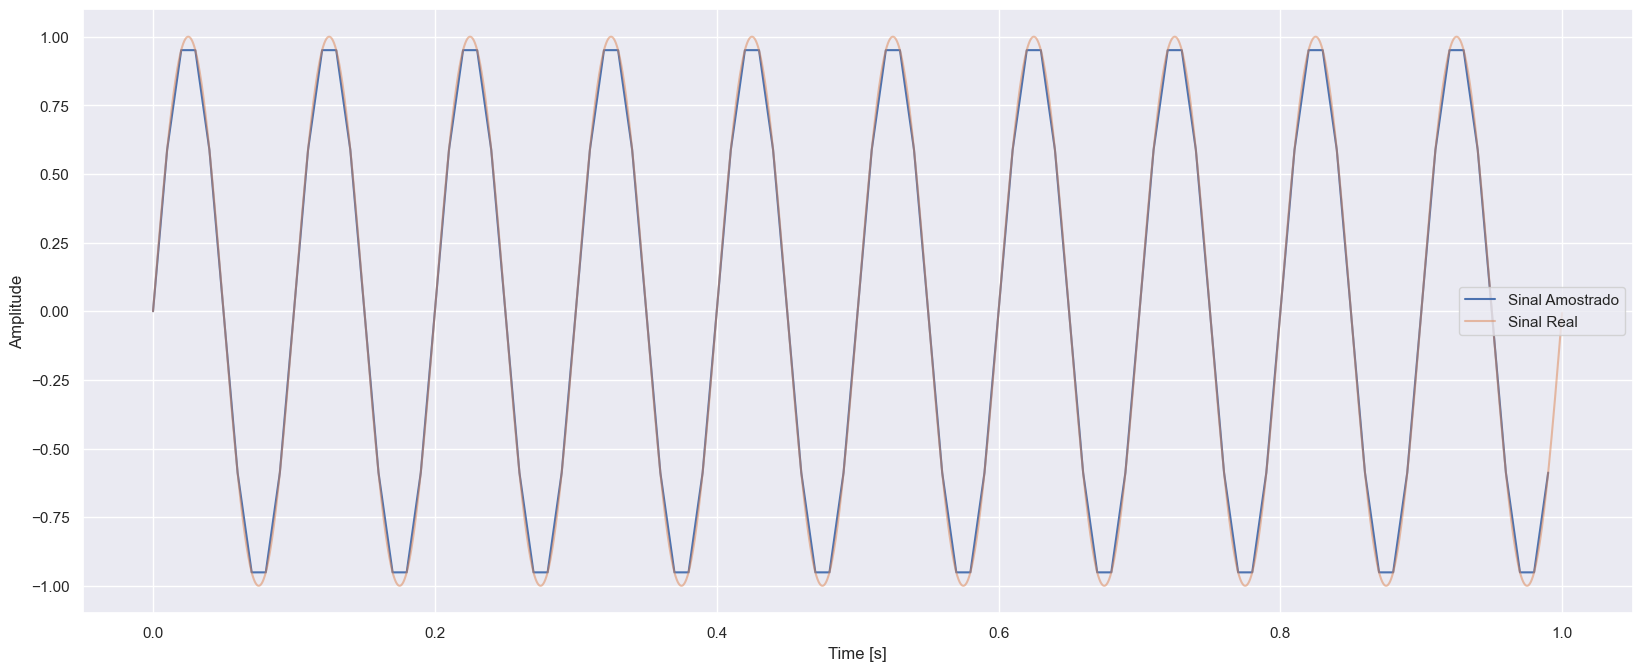

In [3]:
f = 10  # frequência
f_s = 100  # taxa de amostragem
tempo = 1 # segundos

# Senoide original:
t2 = np.linspace(start = 0, stop= tempo, num = 10000,endpoint=False)
senoide = np.sin(f*2*t2*np.pi)

# Sinal medido:
t = np.linspace(start=0, stop=tempo, num=tempo * f_s, endpoint=False)
# t = np.array(range(0, tempo * f_s)) 
sinal = np.sin(f * 2 * np.pi * t)


# sinal = np.sin(2*np.pi*f/f_s*t)
# t = np.linspace(start=0, stop=tempo, num=tempo * f_s, endpoint=False)

fig, ax = plt.subplots()
ax.plot(t, sinal)
ax.plot(t2,senoide, alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.legend(['Sinal Amostrado', 'Sinal Real']);

$$ \begin{equation} x = sin(10 \cdot 2\cdot \pi \cdot t) \end{equation} $$

[-3.40741651e-14-50.j]
[50.]
[-1.57079633]


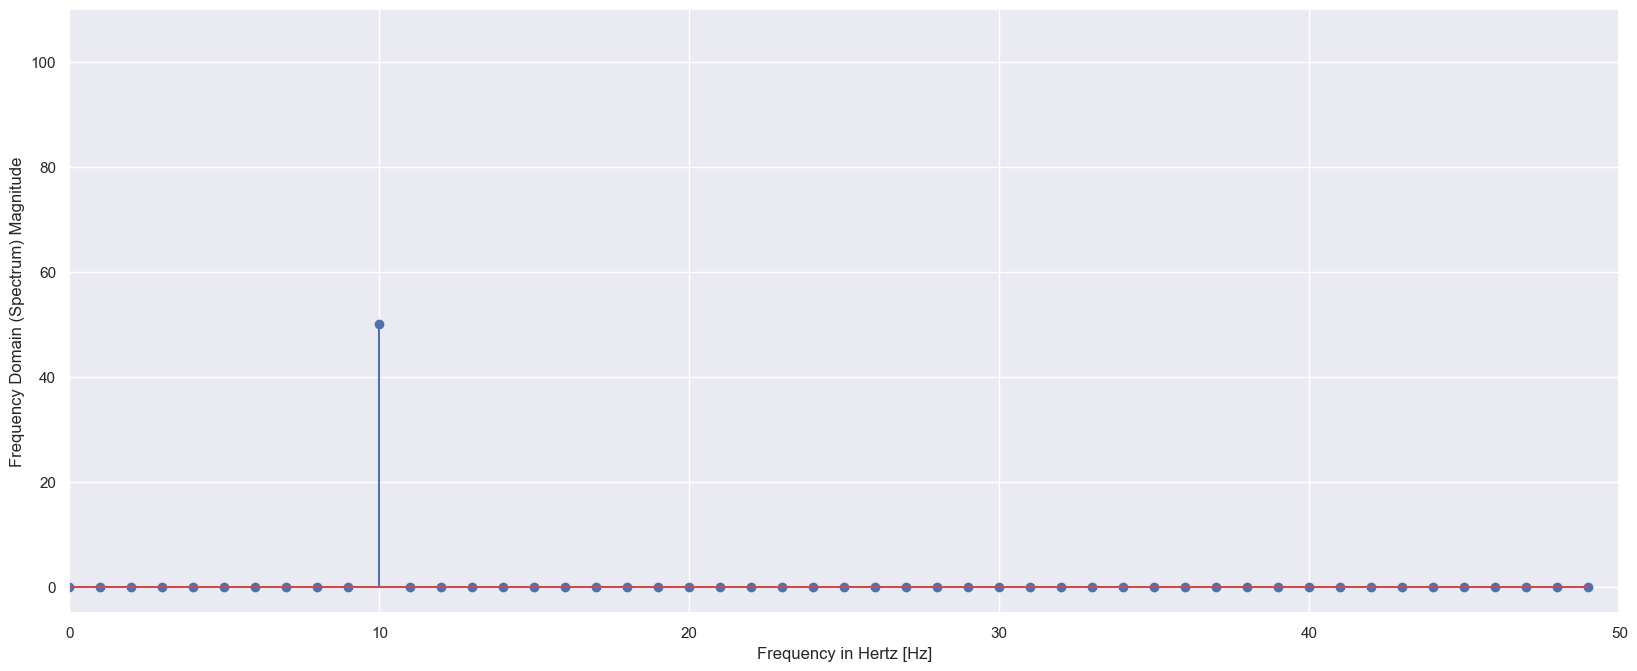

In [4]:
X = fft(sinal)
freqs = fftfreq(len(sinal)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, f_s / 2)
ax.set_ylim(-5, 110);


print(X[freqs == 10])
print(np.abs(X[freqs==10]))
print(np.angle(X[freqs==10]))

<img src = "csm.png"/>

In [5]:
# Determinando limiar de detecção a partir do ruído 
# obs.: varia também em função da taxa de falso positivo desejado (alpha)
def limiar_CSM(alpha, sinal,fs, tamanhoJanela, M, bins):

    if tamanhoJanela*M > len(sinal):
        print('Erro no número de janelas (ou amostras,M) escolhido.\n Retornando 0.')
        return 0
    else:
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

        X = fft(sinal)
        # freqs = fftfreq(len(sinal))*fs
        # fases = np.angle(X[freqs == f0])
        fases = np.angle(X[bins])

        CSM = (sum(np.cos(fases))/M)**2 + (sum(np.sin(fases)))**2
        
        
        return np.quantile(CSM, 1-alpha)

alpha = 5/100
M = 300
limiar = limiar_CSM(alpha, sinal = rd.randn(10**6), fs= f_s, tamanhoJanela=42, M= 300, bins = 1) # Tamanho da janela escolhido arbitrariamente 
print(limiar)

# limiares = []
# for M in [10**3,10**4, 10**6]:
#     limiares.append(limiar_CSM(alpha, sinal = rd.randn(10**8), fs = f_s, tamanhoJanela=100, M= M, bins =1))

# print(np.mean(limiares))
# print(limiares)

0.002900012032110562


In [6]:
from scipy.stats.distributions import chi2
# Valor teórico do limiar: (perguntar)
alpha = 5/100
M = 300
limiar = chi2.ppf(1-alpha,df=2)/(2*M)

print('Vamos usar o limiar teórico:')
print(limiar)

Vamos usar o limiar teórico:
0.009985774245179964


In [58]:
def ord_CSM(alpha, sinal,fs, tamanhoJanela, M, bins):

    if len(sinal)-tamanhoJanela*M>=0:
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

        X = fft(sinal)
        freqs = fftfreq(len(sinal))*fs
        fases = np.angle(X)

        CSM = (np.sum(np.cos(fases),axis=1)/M)**2 + (np.sum(np.sin(fases),axis=1)/M)**2

        return  CSM
    else:
        print('Erro no número de janelas', tamanhoJanela,'(ou amostras,M =', M,') escolhido.')
        print(len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0        

In [87]:
# Parâmetros de Simulação:
amostras = 10 # num de "indivíduos"

# Confiança desejada: (5% = padrão, 1% = "rigoroso")
alpha = 5/100 

listaSNRs = np.linspace(-50,50,1000)
probDetec = np.zeros((len(listaSNRs),1))


# Para f0 = 10 Hz e fs = 100 Hz, para amostrar janelas de 1 segundo:
tamanhoJanela = 100 

M = 300
bins = 10

f = 10  # frequência
f_s = 100  # taxa de amostragem
N = M*tamanhoJanela # segundos =tempo * f_s

# Sinal:
t = np.array(range(0, N)) #, endpoint=False)
# sinal = np.sin(f * 2 * np.pi * t)
sinal = np.sin(2*np.pi*f/f_s*t)

# gerando ruido:
energiaRuido = 1 # coincide com amplitude máx do ruido, supondo que média do ruido é aprox. 0
ruido = energiaRuido*rd.randn(amostras,len(sinal)) 
ORD = np.zeros((len(listaSNRs),amostras,tamanhoJanela))

print('Simulando')
for amostra in range(amostras):
    for i, SNRi in enumerate(listaSNRs):
        amplitude = 10**(SNRi/20)*(energiaRuido**2)
        
        x = ruido[amostra,:] +(np.multiply(amplitude,sinal))
        
        # xHist[i,amostra,:]= x

        ORD[i,amostra,:] = ord_CSM(alpha, x, f_s, tamanhoJanela, M, bins)

        

print('Done')



Simulando
Done


316.22776601683796
316.22776601683796
0.009985774245179964


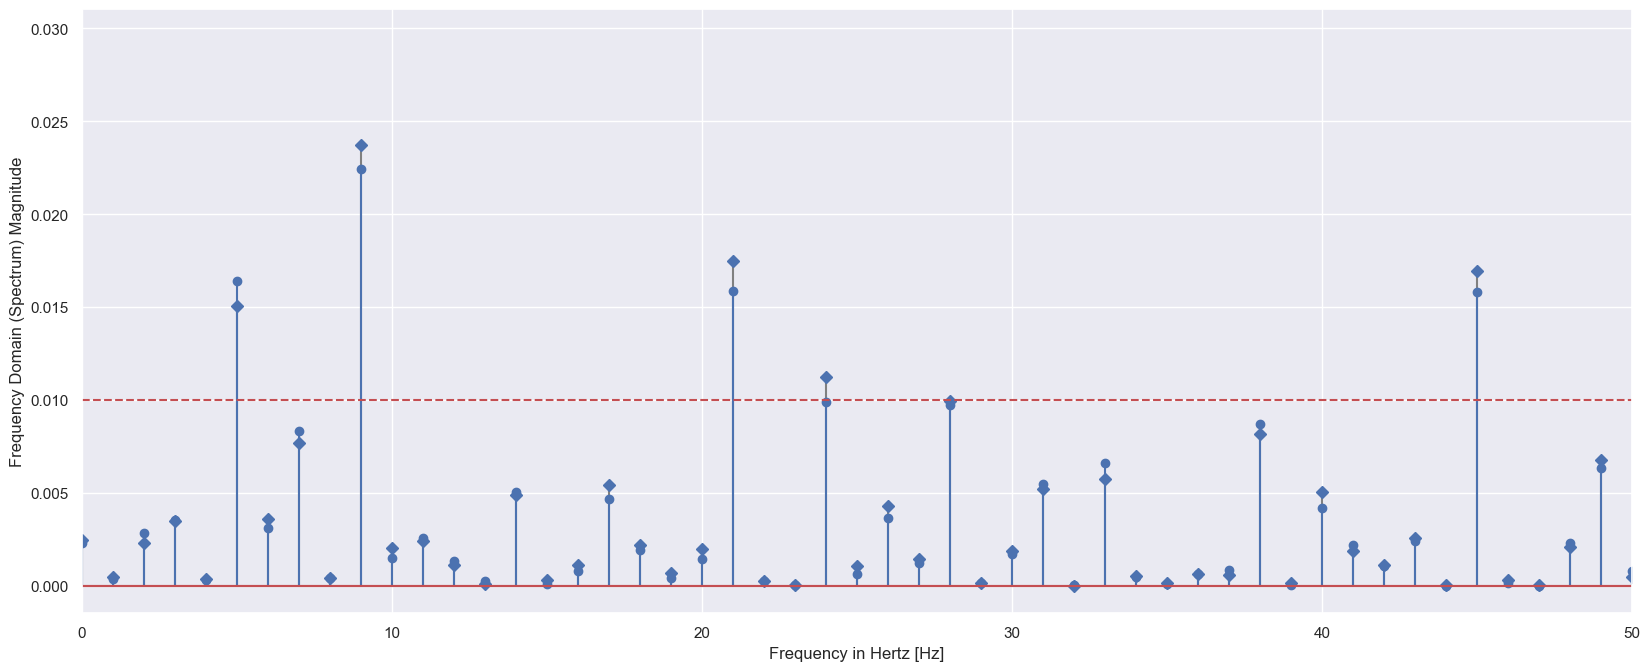

In [108]:

fig, ax = plt.subplots()
iiSNR = 1
# X = fft(ORD[iiSNR][0][:])
# freqs = fftfreq(len(ORD[iiSNR][0][:])) * f_s

print(10**(SNRi/20)*(energiaRuido**2))
sinal = np.sin(2*np.pi*f/f_s*t)
x = ruido[2,:] +(np.multiply(amplitude,sinal))
ax.stem(ORD[iiSNR][3][:],linefmt='grey', markerfmt='D')

iiSNR = -1
# X = fft(ORD[iiSNR][0][:])
# freqs = fftfreq(len(ORD[iiSNR][0][:])) * f_s

print(10**(SNRi/20)*(energiaRuido**2))
sinal = np.sin(2*np.pi*f/f_s*t)
x = ruido[2,:] +(np.multiply(amplitude,sinal))

# ax.stem(freqs, np.abs(X))
ax.stem(ORD[iiSNR][3][:])
plt.axhline(limiar, 0,1,c='r',linestyle='--')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, f_s / 2)
# ax.set_ylim(-5, 110);
print(limiar)

# print(X[freqs == 10])
# print(np.abs(X[freqs==10]))
# print(np.angle(X[freqs==10]))

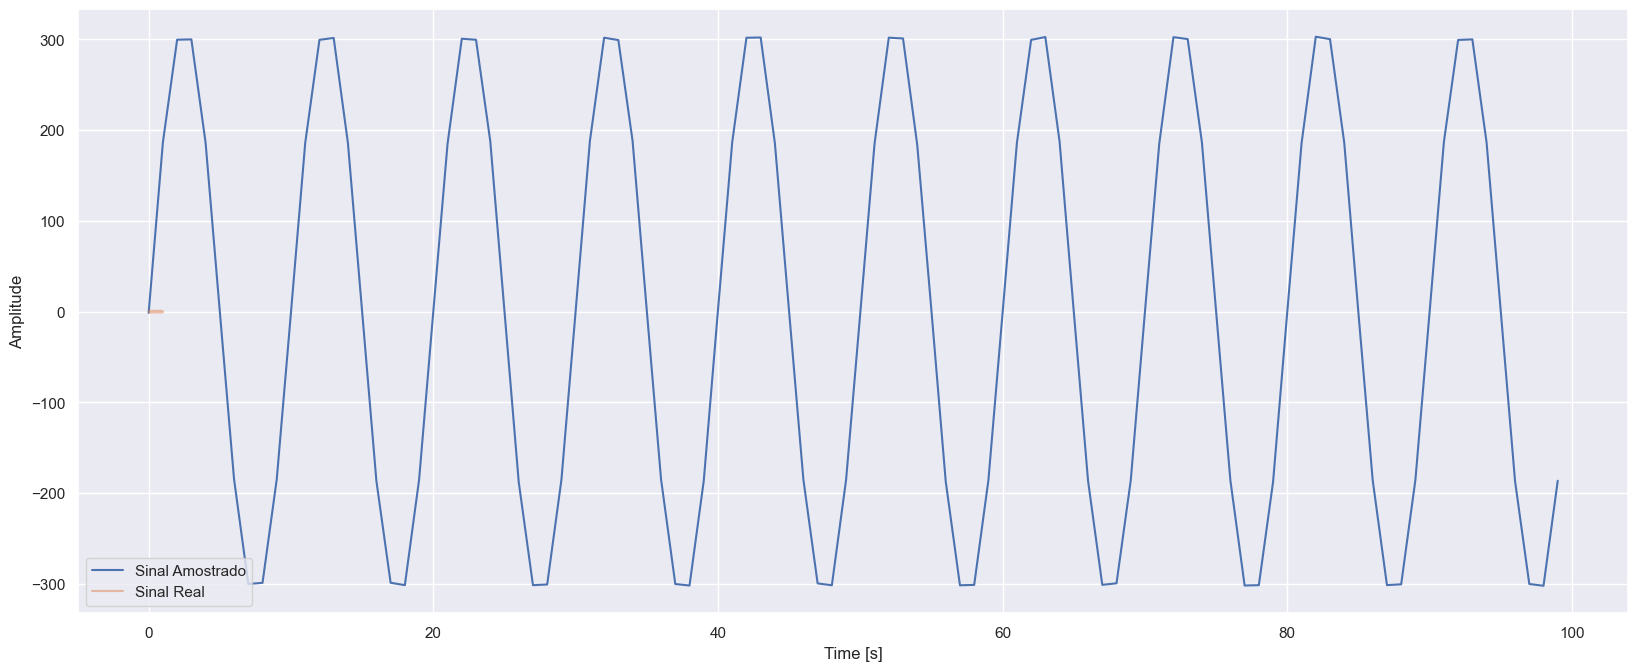

In [98]:
fig, ax = plt.subplots()
ax.plot(x[0:100])
ax.plot(t2,senoide, alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.legend(['Sinal Amostrado', 'Sinal Real']);


In [74]:
pD = pd.DataFrame({'snr': listaSNRs,'prob':probDetect[:][2]*100})
sns.lineplot(data = pD,x='snr',y='prob');
print(probDetect[-1,0])

ValueError: Data must be 1-dimensional

In [ ]:
# amplitude = 10**(listaSNRs[round(len(listaSNRs)/2)]/20)*(energiaRuido**2)

# %plotar valores críticos
# alfa = 0.05;
# L = 10; 

# f = 10; 
# fs = 100; 
# N = 1000; 
# amplitude_ruido = 10; 
# A =1;

# %
# [~,VC_teorico] = VC_LFT(L,alfa,2);
# s(:,1) = sin(2*pi*f/fs*[0:(N-1)]);
# x = A *s + amplitude_ruido*randn(N,1); 